![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# Train Financial NER

In [0]:
from johnsnowlabs import * 

# CoNLL Data Prep

In [0]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/conll_noO.conll

dbutils.fs.cp("file:/databricks/driver/conll_noO.conll", "dbfs:/") 

Out[3]: True

In [0]:
with open("/dbfs/conll_noO.conll") as f:
    train_txt =f.read()

print(train_txt[:500])

( NN NN O
d NN NN O
) NN NN O
OF NN NN O
THE NN NN O
SECURITIES NN NN O
EXCHANGE NN NN O
ACT NN NN O
OF NN NN O
1934 NN NN O
For NN NN O
the NN NN O
annual NN NN O
period NN NN O
ended NN NN O
March NNP NNP B-FISCAL_YEAR
31 NNP NNP I-FISCAL_YEAR
, NNP NNP I-FISCAL_YEAR
2021 NNP NNP I-FISCAL_YEAR
March NNP NNP B-FISCAL_YEAR
31 NNP NNP I-FISCAL_YEAR
, NNP NNP I-FISCAL_YEAR
2021 NNP NNP I-FISCAL_YEAR
☐ NN NN O
TRANSITION NN NN O
REPORT NN NN O
UNDER NN NN O
SECTION NN NN O
13 NN NN O
OR NN NN O
15

In [0]:
from sparknlp.training import CoNLL

training_data = nlp.CoNLL().readDataset(spark, 'dbfs:/conll_noO.conll')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
( d ) OF THE SECU...|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 0, (,...|[{pos, 0, 0, NN, ...|[{named_entity, 0...|
﻿ COMPANY BACKGRO...|[{document, 0, 13...|[{document, 0, 13...|[{token, 0, 0, ﻿,...|[{pos, 0, 0, NN, ...|[{named_entity, 0...|
In November 2004 ...|[{document, 0, 11...|[{document, 0, 11...|[{token, 0, 1, In...|[{pos, 0, 1, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
training_data.printSchema()

root
-- text: string (nullable = true)
-- document: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- sentence: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- token: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- pos: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- label: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)

In [0]:
%time training_data.count()

CPU times: user 574 ms, sys: 245 ms, total: 819 ms
Wall time: 2min 54s
Out[7]: 1637

In [0]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip(training_data.token.result, 
                                            training_data.pos.result, 
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("pos"),
                     F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+-------------+
 token|pos| ner_label|
+----------+---+-------------+
 (| NN| O|
 d| NN| O|
 )| NN| O|
 OF| NN| O|
 THE| NN| O|
SECURITIES| NN| O|
 EXCHANGE| NN| O|
 ACT| NN| O|
 OF| NN| O|
 1934| NN| O|
 For| NN| O|
 the| NN| O|
 annual| NN| O|
 period| NN| O|
 ended| NN| O|
 March|NNP|B-FISCAL_YEAR|
 31|NNP|I-FISCAL_YEAR|
 ,|NNP|I-FISCAL_YEAR|
 2021|NNP|I-FISCAL_YEAR|
 March|NNP|B-FISCAL_YEAR|
+----------+---+-------------+
only showing top 20 rows

In [0]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------------+-----+
ground_truth |count|
+------------------+-----+
O |51912|
I-DATE |1932 |
I-FISCAL_YEAR |1812 |
B-DATE |1797 |
B-AMOUNT |1466 |
B-CURRENCY |1461 |
I-AMOUNT |1134 |
B-FISCAL_YEAR |605 |
I-EXPENSE_INCREASE|546 |
I-EXPENSE_DECREASE|390 |
B-PERCENTAGE |350 |
I-PROFIT_INCREASE |288 |
I-EXPENSE |280 |
B-EXPENSE_INCREASE|274 |
I-PROFIT |228 |
B-EXPENSE_DECREASE|191 |
B-PROFIT_INCREASE |164 |
B-EXPENSE |150 |
B-PROFIT |122 |
I-PROFIT_DECLINE |93 |
B-PROFIT_DECLINE |58 |
I-PERCENTAGE |12 |
+------------------+-----+

# Using Bert Embeddings

In [0]:
bert_embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base", "en") \
    .setInputCols("sentence", "token") \
    .setOutputCol("embeddings")\
    .setMaxSentenceLength(512)

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][OK!]

In [0]:
nerTagger = finance.NerApproach()\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(2)\
    .setLr(0.003)\
    .setBatchSize(32)\
    .setRandomSeed(0)\
    .setVerbose(1)\
    .setValidationSplit(0.2)\
    .setEvaluationLogExtended(True) \
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setOutputLogsPath('dbfs:/ner/ner_logs') # if not set, logs will be written to ~/annotator_logs
#    .setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
#    .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 

ner_pipeline = Pipeline(
    stages=[
        bert_embeddings,
        nerTagger
    ])

In [0]:
%%time

ner_model = ner_pipeline.fit(training_data)

# 1 epoch takes around 3 min with batch size=32
# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

CPU times: user 414 ms, sys: 182 ms, total: 595 ms
Wall time: 2min 19s

In [0]:
import os

log_files = os.listdir("/dbfs/ner/ner_logs")
with open("/dbfs/ner/ner_logs/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: /databricks/driver/file:/local_disk0/tmp/sparknlp_tmp_8113994982946629813/blstm_12_200_128_85.pb
Training started - total epochs: 3 - lr: 0.001 - batch size: 64 - labels: 3 - chars: 82 - training examples: 2606


Epoch 1/3 started, lr: 0.001, dataset size: 2606


Epoch 1/3 - 12.05s - loss: 467.7205 - avg training loss: 10.877221 - batches: 43
Quality on validation dataset (20.0%), validation examples = 521
time to finish evaluation: 1.92s
Total validation loss: 62.2711	Avg validation loss: 4.7901
label tp fp fn prec rec f1
I-Disease 271 160 461 0.6287703 0.37021858 0.4660361
B-Disease 219 104 410 0.67801857 0.3481717 0.46008405
tp: 490 fp: 264 fn: 871 labels: 2
Macro-average prec: 0.65339446, rec: 0.35919514, f1: 0.46355626
Micro-average prec: 0.64986736, rec: 0.3600294, f1: 0.46335697
Quality on test dataset: 
time to finish evaluation: 1.61s
Total test loss: 72.1008	Avg test loss: 5.1501
label tp fp fn prec rec f1
I-Disease 294 202 495 0.5927419 0.37262356 0.45758754
B-Disease 204 113 504 0.6435331 0.2881356 0.39804876
tp: 498 fp: 315 fn: 999 labels: 2
Macro-average prec: 0.6181375, rec: 0.33037958, f1: 0.430609
Micro-average prec: 0.61254615, rec: 0.33266532, f1: 0.43116882


Epoch 2/3 started, lr: 9.950249E-4, dataset size: 2606


Epoch 2/3 - 11.02s - loss: 188.62544 - avg training loss: 4.386638 - batches: 43
Quality on validation dataset (20.0%), validation examples = 521
time to finish evaluation: 1.51s
Total validation loss: 45.1901	Avg validation loss: 3.4762
label tp fp fn prec rec f1
I-Disease 389 162 343 0.7059891 0.53142077 0.6063913
B-Disease 313 106 316 0.7470167 0.49761525 0.5973282
tp: 702 fp: 268 fn: 659 labels: 2
Macro-average prec: 0.7265029, rec: 0.514518, f1: 0.60240537
Micro-average prec: 0.7237113, rec: 0.5157972, f1: 0.6023166
Quality on test dataset: 
time to finish evaluation: 1.59s
Total test loss: 54.5572	Avg test loss: 3.8969
label tp fp fn prec rec f1
I-Disease 404 186 385 0.6847458 0.51204056 0.58593184
B-Disease 338 112 370 0.7511111 0.47740114 0.5837651
tp: 742 fp: 298 fn: 755 labels: 2
Macro-average prec: 0.7179284, rec: 0.49472085, f1: 0.5857822
Micro-average prec: 0.7134615, rec: 0.49565798, f1: 0.5849428


Epoch 3/3 started, lr: 9.90099E-4, dataset size: 2606


Epoch 3/3 - 10.85s - loss: 177.52261 - avg training loss: 4.1284328 - batches: 43
Quality on validation dataset (20.0%), validation examples = 521
time to finish evaluation: 1.51s
Total validation loss: 45.6946	Avg validation loss: 3.5150
label tp fp fn prec rec f1
I-Disease 528 345 204 0.604811 0.72131145 0.65794384
B-Disease 425 140 204 0.7522124 0.6756757 0.7118927
tp: 953 fp: 485 fn: 408 labels: 2
Macro-average prec: 0.67851174, rec: 0.6984936, f1: 0.6883577
Micro-average prec: 0.662726, rec: 0.7002204, f1: 0.68095744
Quality on test dataset: 
time to finish evaluation: 1.66s
Total test loss: 50.5538	Avg test loss: 3.6110
label tp fp fn prec rec f1
I-Disease 551 386 238 0.58804697 0.69835234 0.6384704
B-Disease 457 135 251 0.7719595 0.6454802 0.70307696
tp: 1008 fp: 521 fn: 489 labels: 2
Macro-average prec: 0.6800032, rec: 0.67191625, f1: 0.67593557
Micro-average prec: 0.65925443, rec: 0.6733467, f1: 0.6662261

![2.jpg](/files/FINLEG/2.jpg)

### Splitting Dataset Into Train and Test Set

Also we will use `.setTestDataset('ner_dl_test.parquet')` for checking test-loss values of each epoch in the logs file and `.useBestModel(True)` parameter whether to restore and use the model that has achieved the best performance at the end of the training. .

In [0]:
conll_data = nlp.CoNLL().readDataset(spark, 'dbfs:/conll_noO.conll')

(train_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 1101
Test Dataset Count: 536

In [0]:
!mkdir /dbfs/ner/ner_logs_best

In [0]:
bert_embeddings.transform(test_data).write.parquet('/dbfs/ner_dl_test.parquet')

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-2781238766634717> in <module> 
 ----> 1 bert_embeddings . transform ( test_data ) . write . parquet ( '/dbfs/ner_dl_test.parquet' ) 

 /databricks/spark/python/pyspark/sql/readwriter.py in parquet (self, path, mode, partitionBy, compression) 
 1275 self . partitionBy ( partitionBy ) 
 1276 self . _set_opts ( compression = compression ) 
 -> 1277 self . _jwrite . parquet ( path ) 
 1278 
 1279 def text ( self , path , compression = None , lineSep = None ) : 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 121 # Hide where the exception came from that shows a non-Pythonic 
 122 # JVM exception message. 
 --> 123 raise converted from None 
 124 else : 
 125 raise 

 AnalysisException : path dbfs:/dbfs/ner_dl_test.parquet already exists.

In [0]:
nerTagger = finance.NerApproach()\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(3)\
    .setLr(0.003)\
    .setBatchSize(32)\
    .setRandomSeed(0)\
    .setVerbose(1)\
    .setValidationSplit(0.2)\
    .setEvaluationLogExtended(True) \
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setUseBestModel(True)\
    .setTestDataset('/dbfs/ner_dl_test.parquet')\
    .setOutputLogsPath('dbfs:/ner/ner_logs_best') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(
    stages=[
        bert_embeddings,
        nerTagger
    ])

In [0]:
%%time
ner_model = ner_pipeline.fit(train_data)

CPU times: user 448 ms, sys: 217 ms, total: 664 ms
Wall time: 2min 29s

In [0]:
log_files = os.listdir("/dbfs/ner/ner_logs_best")
log_files

Out[68]: ['NerDLApproach_d01c8b8d0c8c.log']

In [0]:
with open("/dbfs/ner/ner_logs_best/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 3 - lr: 0.003 - batch size: 32 - labels: 22 - chars: 92 - training examples: 873


Epoch 1/3 started, lr: 0.003, dataset size: 873


Epoch 1/3 - 11.47s - loss: 1014.7047 - batches: 29
Quality on validation dataset (20.0%), validation examples = 174
time to finish evaluation: 1.34s
label tp fp fn prec rec f1
I-AMOUNT 152 9 2 0.94409937 0.987013 0.96507937
B-AMOUNT 191 22 2 0.8967136 0.9896373 0.94088674
B-DATE 205 16 54 0.9276018 0.7915058 0.8541666
I-DATE 269 24 27 0.91808873 0.9087838 0.9134125
I-EXPENSE 0 2 29 0.0 0.0 0.0
B-PROFIT_INCREASE 0 0 19 0.0 0.0 0.0
B-EXPENSE 0 0 16 0.0 0.0 0.0
I-PERCENTAGE 0 0 2 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 27 0.0 0.0 0.0
I-PROFIT 0 0 23 0.0 0.0 0.0
B-CURRENCY 192 13 0 0.93658537 1.0 0.9672544
I-PROFIT_INCREASE 0 0 25 0.0 0.0 0.0
B-PROFIT 0 0 13 0.0 0.0 0.0
B-PERCENTAGE 45 1 5 0.9782609 0.9 0.9375
I-FISCAL_YEAR 293 24 7 0.92429024 0.9766667 0.9497569
B-PROFIT_DECLINE 0 0 14 0.0 0.0 0.0
B-EXPENSE_INCREASE 6 8 39 0.42857143 0.13333334 0.20338984
B-EXPENSE_DECREASE 1 3 20 0.25 0.04761905 0.080000006
B-FISCAL_YEAR 98 8 2 0.9245283 0.98 0.9514563
I-EXPENSE_DECREASE 0 1 47 0.0 0.0 0.0
I-EXPENSE_INCREASE 35 86 50 0.2892562 0.4117647 0.3398058
tp: 1487 fp: 217 fn: 423 labels: 21
Macro-average prec: 0.4008569, rec: 0.3869678, f1: 0.39378992
Micro-average prec: 0.8726526, rec: 0.77853405, f1: 0.8229109
Quality on test dataset: 
time to finish evaluation: 2.06s
label tp fp fn prec rec f1
I-AMOUNT 352 13 13 0.96438354 0.96438354 0.96438354
B-AMOUNT 460 37 3 0.9255533 0.9935205 0.9583333
B-DATE 420 54 213 0.886076 0.6635071 0.7588076
I-DATE 580 53 101 0.91627175 0.8516887 0.88280064
I-EXPENSE 0 2 108 0.0 0.0 0.0
B-PROFIT_INCREASE 0 0 57 0.0 0.0 0.0
B-EXPENSE 0 0 57 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 23 0.0 0.0 0.0
I-PROFIT 0 0 72 0.0 0.0 0.0
B-CURRENCY 461 20 1 0.95842 0.9978355 0.9777307
I-PROFIT_INCREASE 0 0 110 0.0 0.0 0.0
B-PROFIT 0 0 38 0.0 0.0 0.0
B-PERCENTAGE 95 2 16 0.97938144 0.8558559 0.9134616
I-FISCAL_YEAR 557 85 20 0.8676013 0.96533793 0.91386384
B-PROFIT_DECLINE 0 0 13 0.0 0.0 0.0
B-EXPENSE_INCREASE 13 16 78 0.44827586 0.14285715 0.21666667
B-EXPENSE_DECREASE 1 9 41 0.1 0.023809524 0.03846154
B-FISCAL_YEAR 186 26 6 0.8773585 0.96875 0.9207921
I-EXPENSE_DECREASE 0 4 86 0.0 0.0 0.0
I-EXPENSE_INCREASE 81 133 115 0.37850466 0.41326532 0.39512196
tp: 3206 fp: 454 fn: 1171 labels: 20
Macro-average prec: 0.41509134, rec: 0.39204055, f1: 0.40323678
Micro-average prec: 0.8759563, rec: 0.73246515, f1: 0.79781014


Epoch 2/3 started, lr: 0.0029850747, dataset size: 873


Epoch 2/3 - 9.64s - loss: 334.42337 - batches: 29
Quality on validation dataset (20.0%), validation examples = 174
time to finish evaluation: 0.83s
label tp fp fn prec rec f1
I-AMOUNT 152 2 2 0.987013 0.987013 0.987013
B-AMOUNT 191 3 2 0.9845361 0.9896373 0.98708016
B-DATE 237 17 22 0.93307084 0.9150579 0.92397654
I-DATE 285 34 11 0.89341694 0.9628378 0.9268292
I-EXPENSE 0 0 29 0.0 0.0 0.0
B-PROFIT_INCREASE 2 2 17 0.5 0.10526316 0.17391305
B-EXPENSE 0 0 16 0.0 0.0 0.0
I-PERCENTAGE 0 0 2 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 27 0.0 0.0 0.0
I-PROFIT 0 0 23 0.0 0.0 0.0
B-CURRENCY 192 3 0 0.9846154 1.0 0.9922481
I-PROFIT_INCREASE 9 3 16 0.75 0.36 0.4864865
B-PROFIT 0 0 13 0.0 0.0 0.0
B-PERCENTAGE 44 1 6 0.9777778 0.88 0.9263157
I-FISCAL_YEAR 283 21 17 0.9309211 0.9433333 0.9370861
B-PROFIT_DECLINE 0 0 14 0.0 0.0 0.0
B-EXPENSE_INCREASE 20 20 25 0.5 0.44444445 0.47058827
B-EXPENSE_DECREASE 1 6 20 0.14285715 0.04761905 0.071428575
B-FISCAL_YEAR 92 6 8 0.93877554 0.92 0.9292929
I-EXPENSE_DECREASE 0 0 47 0.0 0.0 0.0
I-EXPENSE_INCREASE 29 38 56 0.43283582 0.34117648 0.38157892
tp: 1537 fp: 156 fn: 373 labels: 21
Macro-average prec: 0.4740866, rec: 0.42363724, f1: 0.44744438
Micro-average prec: 0.90785587, rec: 0.80471206, f1: 0.8531779
Quality on test dataset: 
time to finish evaluation: 2.09s
label tp fp fn prec rec f1
I-AMOUNT 353 5 12 0.9860335 0.96712327 0.976

In [0]:
# test_data = bert_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()


In [0]:
print(classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))

precision recall f1-score support

 B-AMOUNT 0.9851 1.0000 0.9925 463
 B-CURRENCY 0.9914 0.9978 0.9946 462
 B-DATE 0.9300 0.9021 0.9158 633
 B-EXPENSE 0.5000 0.0175 0.0339 57
B-EXPENSE_DECREASE 0.2371 0.5476 0.3309 42
B-EXPENSE_INCREASE 0.5200 0.1429 0.2241 91
 B-FISCAL_YEAR 0.9261 0.9792 0.9519 192
 B-PERCENTAGE 0.9730 0.9730 0.9730 111
 B-PROFIT 0.0000 0.0000 0.0000 38
 B-PROFIT_DECLINE 0.0000 0.0000 0.0000 13
 B-PROFIT_INCREASE 0.5000 0.3860 0.4356 57
 I-AMOUNT 0.9917 0.9808 0.9862 365
 I-DATE 0.9626 0.9075 0.9342 681
 I-EXPENSE 0.6667 0.0185 0.0360 108
I-EXPENSE_DECREASE 0.2327 0.6628 0.3444 86
I-EXPENSE_INCREASE 0.3390 0.1020 0.1569 196
 I-FISCAL_YEAR 0.9128 0.9983 0.9536 577
 I-PROFIT 0.0000 0.0000 0.0000 72
 I-PROFIT_DECLINE 0.0000 0.0000 0.0000 23
 I-PROFIT_INCREASE 0.6437 0.5091 0.5685 110
 O 0.9739 0.9919 0.9828 17169

 accuracy 0.9546 21546
 macro avg 0.5850 0.5294 0.5150 21546
 weighted avg 0.9467 0.9546 0.9467 21546

In [0]:
from sklearn.metrics import classification_report

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).show(truncate=False)



+----------+-------------+-------------+
token |ground_truth |prediction |
+----------+-------------+-------------+
( |O |O |
d |O |O |
) |O |O |
OF |O |O |
THE |O |O |
SECURITIES|O |O |
EXCHANGE |O |O |
ACT |O |O |
OF |O |O |
1934 |O |O |
For |O |O |
the |O |O |
annual |O |O |
period |O |O |
ended |O |O |
March |B-FISCAL_YEAR|B-FISCAL_YEAR|
31 |I-FISCAL_YEAR|I-FISCAL_YEAR|
, |I-FISCAL_YEAR|I-FISCAL_YEAR|
2021 |I-FISCAL_YEAR|I-FISCAL_YEAR|
March |B-FISCAL_YEAR|O |
+----------+-------------+-------------+
only showing top 20 rows

### Entity level evaluation (strict eval)

In [0]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py

dbutils.fs.cp("file:/databricks/driver/conll_eval.py", "dbfs:/") 

In [0]:
spark.sparkContext.addPyFile("dbfs:/conll_eval.py")
import conll_eval

In [0]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 21546 tokens with 2159 phrases; found: 2087 phrases; correct: 1825.
accuracy: 80.74%; (non-O)
accuracy: 95.51%; precision: 87.45%; recall: 84.53%; FB1: 85.96
 AMOUNT: precision: 95.77%; recall: 97.84%; FB1: 96.79 473
 CURRENCY: precision: 98.72%; recall: 99.78%; FB1: 99.25 467
 DATE: precision: 90.97%; recall: 87.52%; FB1: 89.21 609
 EXPENSE: precision: 0.00%; recall: 0.00%; FB1: 0.00 1
 EXPENSE_DECREASE: precision: 18.75%; recall: 50.00%; FB1: 27.27 112
 EXPENSE_INCREASE: precision: 40.00%; recall: 8.79%; FB1: 14.41 20
 FISCAL_YEAR: precision: 89.90%; recall: 97.40%; FB1: 93.50 208
 PERCENTAGE: precision: 99.08%; recall: 97.30%; FB1: 98.18 109
 PROFIT: precision: 9.09%; recall: 2.63%; FB1: 4.08 11
 PROFIT_DECLINE: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 PROFIT_INCREASE: precision: 41.56%; recall: 56.14%; FB1: 47.76 77

In [0]:
# micro, macro, avg
metrics[0]

Out[61]: (87.44609487302348, 84.52987494210282, 85.96325953838907)

In [0]:
import pandas as pd

pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

Out[62]:

,entity,precision,recall,f1,support
0,AMOUNT,95.771670,97.840173,96.794872,473
1,CURRENCY,98.715203,99.783550,99.246502,467
2,DATE,90.968801,87.519747,89.210950,609
3,EXPENSE,0.000000,0.000000,0.000000,1
4,EXPENSE_DECREASE,18.750000,50.000000,27.272727,112
5,EXPENSE_INCREASE,40.000000,8.791209,14.414414,20
6,FISCAL_YEAR,89.903846,97.395833,93.500000,208
7,PERCENTAGE,99.082569,97.297297,98.181818,109
8,PROFIT,9.090909,2.631579,4.081633,11
9,PROFIT_DECLINE,0.000000,0.000000,0.000000,0


### Ner log parser

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py

dbutils.fs.cp("file:/databricks/driver/ner_log_parser.py", "dbfs:/") 

Out[63]: True

In [0]:
spark.sparkContext.addPyFile("dbfs:/ner_log_parser.py")

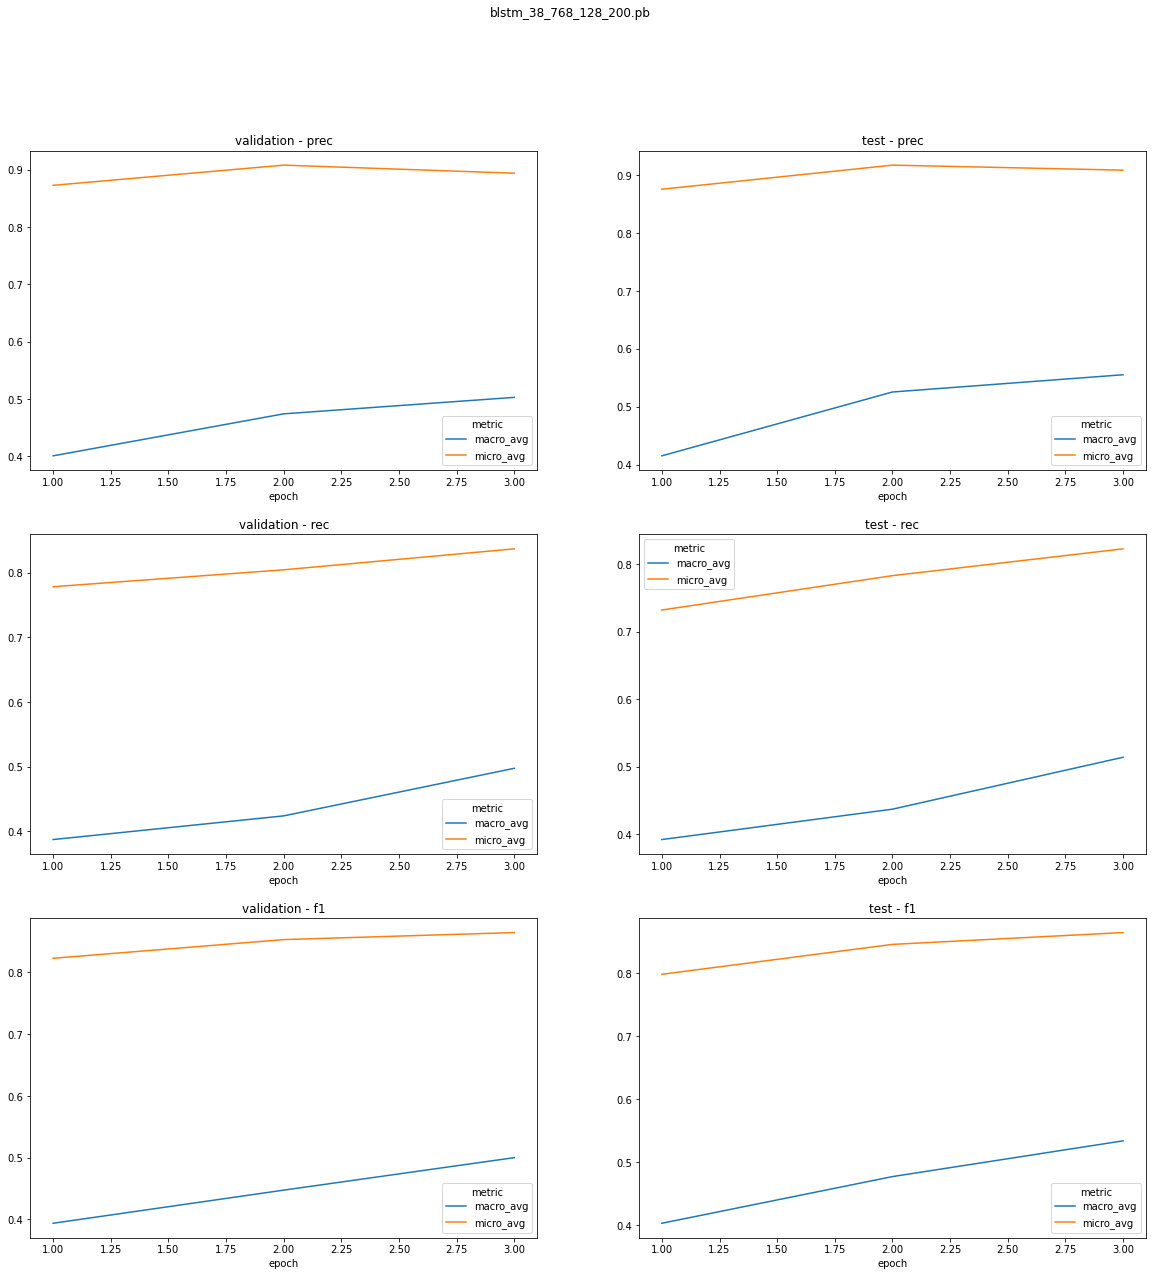

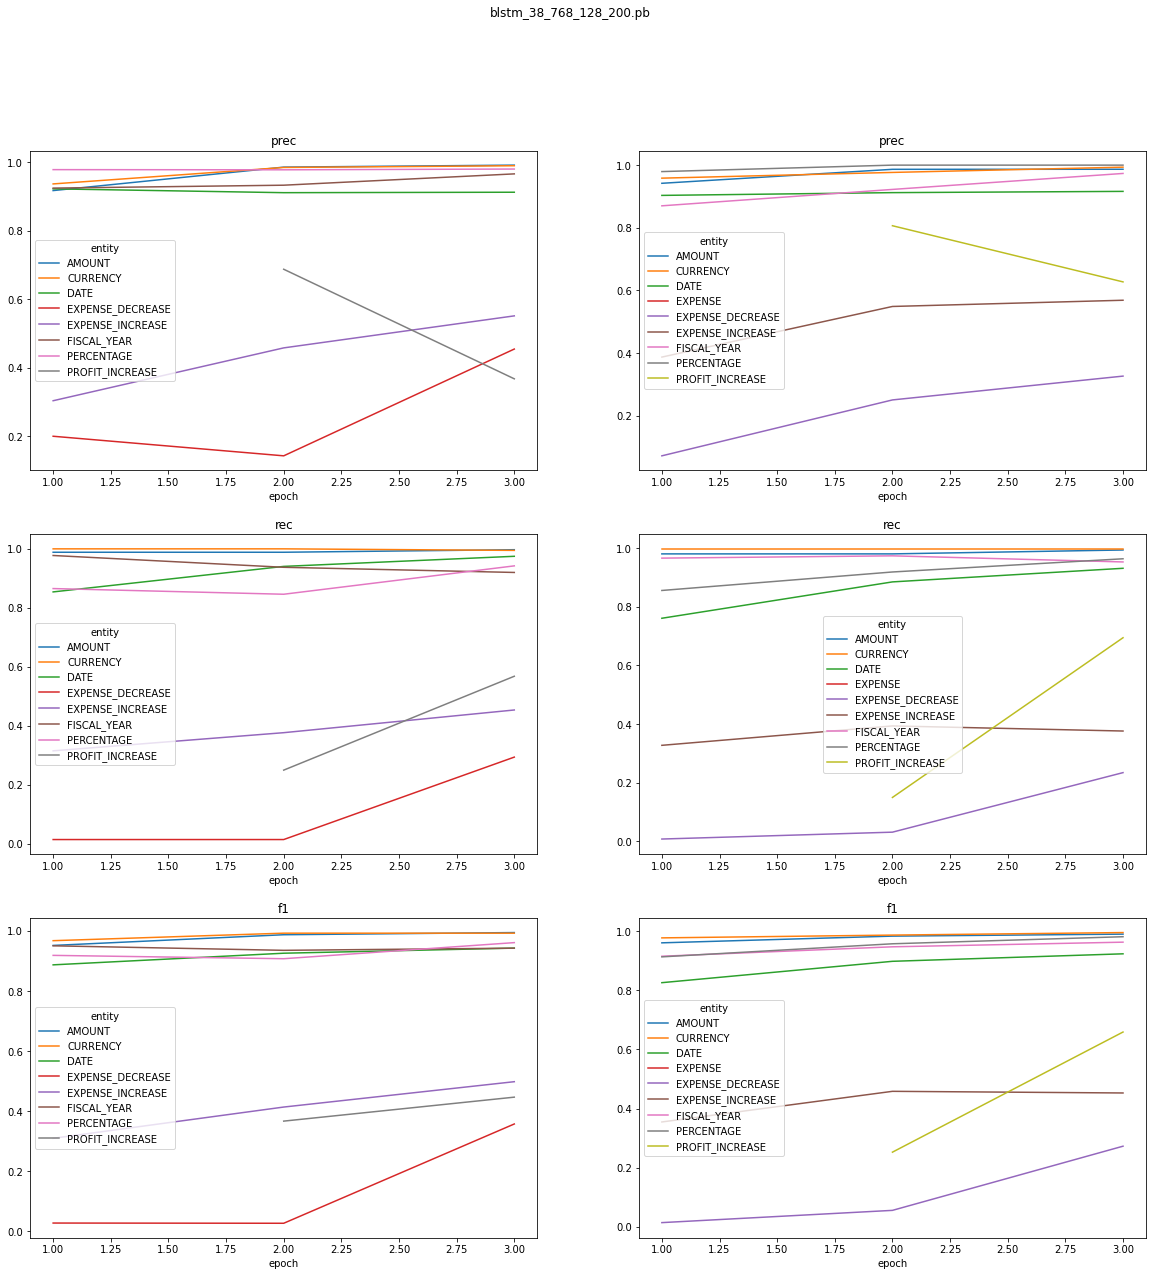

In [0]:
import ner_log_parser

%matplotlib inline

ner_log_parser.get_charts('/dbfs/ner/ner_logs_best/'+log_files[0])

**Plotting Loss**

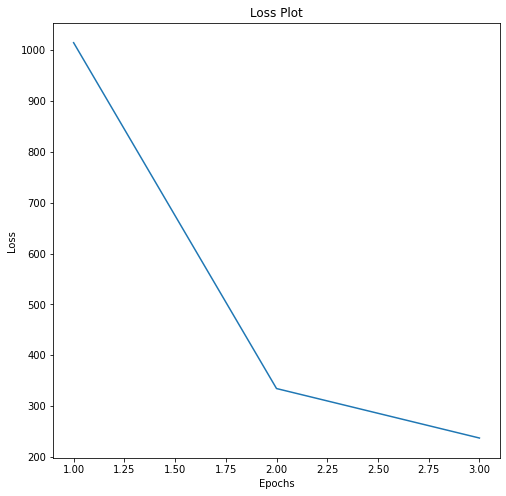

In [0]:
ner_log_parser.loss_plot('/dbfs/ner/ner_logs_best/'+log_files[0])

### Saving the trained model

In [0]:
ner_model.stages

Out[24]: [BERT_EMBEDDINGS_29ce72cd673e, FinanceNerModel_94a487cf0a3e]

In [0]:
ner_model.stages[1].write().overwrite().save('/dbfs/NER_bert_e5_b32')

In [0]:
!ls -lt

total 1824
drwxr-xr-x 2 root root 4096 Oct 17 10:01 logs
drwxr-xr-x 2 root root 4096 Oct 17 10:00 ganglia
-rw-r--r-- 1 root root 1033219 Oct 17 09:54 conll_noO.conll
drwxr-xr-x 3 root root 4096 Oct 17 09:47 eventlogs
-r-xr-xr-x 1 root root 813069 Oct 17 09:46 preload_class.lst
drwxr-xr-x 2 root root 4096 Oct 17 09:46 conf

## Prediction Pipeline

In [0]:
document = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = nlp.SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = nlp.Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

bert_embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base", "en") \
    .setInputCols("sentence", "token") \
    .setOutputCol("embeddings")\
    .setMaxSentenceLength(512)
  
# load trained model
loaded_ner_model = finance.NerModel.load("/dbfs/NER_bert_e5_b32")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = nlp.NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        bert_embeddings,
        loaded_ner_model,
        converter
    ])

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[ | ][OK!]

In [0]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

In [0]:
text = """$ 4.2 million of the increase was compensation related and primarily attributable to an increase in headcount to support the continued growth of our subscription SaaS offerings and ongoing maintenance and support for our expanding customer base ."""

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
text |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
$ 4.2 million of the increase was compensation related and primarily attributable to an increase in headcount to support the continued growth of our subscription SaaS offerings and ongoing maintenance and support for our expanding customer base .|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

In [0]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,
                                    preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+-----------+--------+
chunk |entity |
+-----------+--------+
$ |CURRENCY|
4.2 million|AMOUNT |
+-----------+--------+

In [0]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [0]:
text = """$ 4.2 million of the increase was compensation related and primarily attributable to an increase in headcount to support the continued growth of our subscription SaaS offerings and ongoing maintenance and support for our expanding customer base ."""

result_ann = light_model.annotate(text)

list(zip(result_ann['token'], result_ann['ner']))

Out[84]: [('$', 'B-CURRENCY'),
 ('4.2', 'B-AMOUNT'),
 ('million', 'I-AMOUNT'),
 ('of', 'O'),
 ('the', 'O'),
 ('increase', 'O'),
 ('was', 'O'),
 ('compensation', 'O'),
 ('related', 'O'),
 ('and', 'O'),
 ('primarily', 'O'),
 ('attributable', 'O'),
 ('to', 'O'),
 ('an', 'O'),
 ('increase', 'O'),
 ('in', 'O'),
 ('headcount', 'O'),
 ('to', 'O'),
 ('support', 'O'),
 ('the', 'O'),
 ('continued', 'O'),
 ('growth', 'O'),
 ('of', 'O'),
 ('our', 'O'),
 ('subscription', 'O'),
 ('SaaS', 'O'),
 ('offerings', 'O'),
 ('and', 'O'),
 ('ongoing', 'O'),
 ('maintenance', 'O'),
 ('and', 'O'),
 ('support', 'O'),
 ('for', 'O'),
 ('our', 'O'),
 ('expanding', 'O'),
 ('customer', 'O'),
 ('base', 'O'),
 ('.', 'O')]

In [0]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

Out[85]:

,sent_id,token,start,end,ner
0,0,$,0,0,B-CURRENCY
1,0,4.2,2,4,B-AMOUNT
2,0,million,6,12,I-AMOUNT
3,0,of,14,15,O
4,0,the,17,19,O
5,0,increase,21,28,O
6,0,was,30,32,O
7,0,compensation,34,45,O
8,0,related,47,53,O
9,0,and,55,57,O


### **Highlight Entities**

In [0]:
from sparknlp_display import NerVisualizer


result = result[0]
visualiser = NerVisualizer()
viz = visualiser.display(result, label_col='ner_span', document_col='document',return_html=True)
displayHTML(viz)

$ CURRENCY 4.2 million AMOUNT of the increase was compensation related and primarily attributable to an increase in headcount to support the continued growth of our subscription SaaS offerings and ongoing maintenance and support for our expanding customer base .

# NerDL Graph

Licensed users would use this module to create graphs for each DL model (`ner_dl`, `generic_classifier`, `assertion_dl`, `relation_extraction`) in Spark NLP but in open source, you need to run the other cell.

```
from sparknlp_jsl.training import tf_graph

tf_graph.build("ner_dl", build_params={"embeddings_dim": 200, "nchars": 80, "ntags": 12}, model_location="./", model_filename="auto")
```

In [0]:
# %%capture

# !wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
# !wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
# !wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
# !wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
# !wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py

# %tensorflow_version 2.7.0

# import create_graph

# ntags = 19 # number of labels
# embeddings_dim = 100
# nchars =100

# create_graph.create_graph(ntags, embeddings_dim, nchars)

# # then move the graph to grap folder stated in NerDLApproach